<h1 style="font-size: 36px;"><strong>Genetic Algorithm for Drawing</strong></h1>


**Introduction to Genetic Algorithms**

A genetic algorithm (GA) is a search heuristic inspired by the process of natural selection. It is commonly used to find approximate solutions to optimization and search problems. The basic idea is to evolve a population of candidate solutions (individuals) over several generations to maximize (or minimize) a fitness function. The main steps in a genetic algorithm are:
1. Initialization: Start with a randomly generated population of individuals.
2. Evaluation: Assess the fitness of each individual in the population.
3. Selection: Select individuals based on their fitness to become parents for the next generation.
4. Crossover: Combine pairs of parents to produce offspring, introducing genetic diversity.
5. Mutation: Apply random changes to offspring to maintain genetic diversity.
6. Replacement: Form a new population by replacing some or all of the old population with the new offspring.
7. Termination: Repeat steps 2-6 until a stopping criterion is met (e.g., a maximum number of generations or a satisfactory fitness level).

**Genetic Algorithm for Mimicking a Reference Image**

The goal of this genetic algorithm is to mimic a reference image using random circles of different colors, sizes, and opacities. Each individual in the population represents a potential solution, which is a collection of circles that, when drawn together, approximate the reference image.

Key Components:
- Chromosome: A single solution represented by a list of circles. Each circle is defined by its position ( x , y), radius, color ( $\mathrm{R}, \mathrm{G}, \mathrm{B}$ ), and opacity (alpha).
- Gene: A single circle within a chromosome.
- Population: A collection of chromosomes (solutions).
- Fitness Function: Measures how closely a chromosome matches the reference image. Lower values indicate a better match, as it is based on the difference between the generated image and the reference image.
- Selection: Uses tournament selection to choose the best chromosomes for reproduction.
- Crossover: Swaps genes between pairs of chromosomes to create new offspring.
- Mutation: Randomly alters genes within chromosomes to introduce new variations.

- `early_stop` controls whether to stop early if a certain fitness level is reached.
- `show_img` controls whether to display intermediate images.
- `save_image_per_generation` determines how often to save images during evolution.
- `img_width` and `img_height` set the dimensions of the images to be processed.
- `max_circle_radius` defines the maximum radius of the circles.
- `num_genes` specifies the number of circles in each chromosome.
- `tm_size` is the tournament size for selection.
- `mutation_type` determines the mutation strategy (guided or unguided).
- `mutation_prob` sets the probability of mutation.
- `num_generation` specifies the maximum number of generations.
- `num_inds` is the number of individuals in the population.
- `frac_elites` and `frac_parents` determine the fractions of elites and parents in the population.
- `num_elites` and `num_parents` are calculated based on the fractions.
- `fit_array` is initialized to store the best fitness values across generations.

**Genetic Algorithm Functions**

1. `create_offsprings`:
Combines elites and mutated parents to create a new population.
2. `init_population`:
Initializes the population with random chromosomes. Each chromosome is a list of circles with random attributes (position, radius, color, opacity).
3. `evaluate_fitness`:
Evaluates the fitness of the population by drawing the circles on a canvas and comparing the result to the reference image using a sum of squared differences.
The best individual is used to draw the canvas for visualization.
4. `draw_canv`:
Draws the canvas with the best chromosome, updating the background image if the new canvas has a better fitness.
5. `mutation`:
Applies mutations to the parents. If the mutation is guided, the changes are made relative to the current gene values.
6. `crossover`:
Combines pairs of parent chromosomes to create offspring, introducing genetic diversity.
7. `tournament_selection`:
Selects parents using tournament selection, preserving a certain number of elites.

**Main Loop**

1. Initialize population:
- The population is initialized with random chromosomes.

2. Evaluate initial fitness:
- The initial fitness of the population is evaluated.

3. Genetic Algorithm Loop:
- If `early_stop` is enabled, the loop continues until a satisfactory fitness level is reached.
- Otherwise, the loop runs for a specified number of generations.
- In each generation:
- Selection: Selects parents and elites.
- Crossover: Creates offspring from parents.
- Mutation: Applies mutations to the offspring.
- Create new population: Combines elites and mutated offspring.
- Evaluate fitness: Evaluates the fitness of the new population.
- Output fitness: Outputs the current fitness and generation number.

4. Plot Fitness Values:
- After the loop, the fitness values across generations are plotted and saved.

fitness value -2731.080753556325 Number of generation 50008

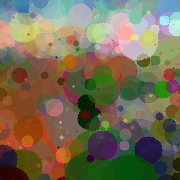

fitness value -2471.6428143021913 Number of generation 6214

KeyboardInterrupt: 

In [2]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from IPython.display import display, Image as IPImage
import io

# Configuration
current_directory = os.getcwd()

# Update paths based on the current directory
image_save_path = os.path.join(current_directory, 'output')
source_img_path = os.path.join(current_directory, 'reference.png')

# Flags for controlling the behavior of the program
early_stop = True
show_img = True
save_image_per_generation = 5000

# Optionally, create the output directory if it doesn't exist
if not os.path.exists(image_save_path):
    os.makedirs(image_save_path)

# Read and convert the source image to RGB format
source_img = cv2.cvtColor(cv2.imread(source_img_path), cv2.COLOR_BGR2RGB)

# Set parameters for the genetic algorithm
img_width, img_height, max_circle_radius, num_genes = 180, 180, 50, 50
tm_size, mutation_type, mutation_prob, num_generation = 20, "guided", 0.2, 100000
num_inds, frac_elites, frac_parents = 20, 0.2, 0.6
num_elites, num_parents = int(num_inds * frac_elites), int(num_inds * frac_parents)

fit_array = []  # Save best fitness value in the population for all generations

# Check if running in Google Colab
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Display image function that works in both environments
def display_image(img):
    if is_colab():
        from google.colab.patches import cv2_imshow
        cv2_imshow(img)
    else:
        _, buffer = cv2.imencode('.png', img)
        io_buf = io.BytesIO(buffer)
        display(IPImage(data=io_buf.getvalue()))

# Create offsprings by combining elites and mutated parents
def create_offsprings(elite_pop, parents_after_mutation):
    return parents_after_mutation + elite_pop

# Initialize the population with random chromosomes
def init_population(num_inds, num_genes):
    pop = []
    for _ in range(num_inds):
        chromosome = [[int((img_width + radius_len / 2) * random.random()), int((img_height + radius_len / 2) * random.random()), radius_len,
                       int(0xff * random.random()), int(0xff * random.random()), int(0xff * random.random()), random.random()]
                      for radius_len in [random.randint(1, max_circle_radius)] * num_genes]
        chromosome.sort(key=lambda x: x[2], reverse=True)
        pop.append(chromosome)
    return pop

# Evaluate fitness of the population
def evaluate_fitness(pop, num_inds, num_genes, background, generation):
    imgg = np.zeros(source_img.shape, dtype=np.uint8)
    for j in range(num_inds):
        pop[j].append(0)
        for i in range(num_genes):
            overlay = background.copy()
            center, rad, rgb, alpha = pop[j][i][:2], pop[j][i][2], pop[j][i][3:6], pop[j][i][6]
            center = (int(center[0]), int(center[1]))
            rad = int(rad)
            cv2.circle(overlay, center, rad, tuple(rgb), -1)
            cv2.addWeighted(overlay, alpha, background, 1 - alpha, 0, imgg)
        pop[j][num_genes] = (-1) * np.sum((imgg / 255 - source_img / 255) ** 2)
    pop.sort(key=lambda agent: agent[num_genes], reverse=True)
    return draw_canv(pop[0], background, generation), pop[0][num_genes]

# Draw the canvas with the best chromosome
def draw_canv(popp, background, generation):
    canvas = np.zeros(source_img.shape, dtype=np.uint8)
    for i in range(num_genes):
        overlay = background.copy()
        center, rad, rgb, alpha = popp[i][:2], popp[i][2], popp[i][3:6], popp[i][6]
        center = (int(center[0]), int(center[1]))
        rad = int(rad)
        cv2.circle(overlay, center, rad, tuple(rgb), -1)
        cv2.addWeighted(overlay, alpha, background, 1 - alpha, 0, canvas)

    fitness_background = (-1) * np.sum((background / 255 - source_img / 255) ** 2)
    fit_array.append(max(popp[num_genes], fitness_background))

    if generation > 0 and generation % save_image_per_generation == 0:
        plt.imshow(canvas)  # Add this line to properly display the image in matplotlib
        plt.axis('off')  # Optionally turn off the axis
        plt.savefig(os.path.join(image_save_path, "img" + str(generation) + ".png"), bbox_inches='tight', pad_inches=0)  # Save image with the correct path and format
        plt.close()  # Close the plot to prevent display in interactive environments

        if show_img:
            canvas_bgr = cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR)  # Convert the canvas to BGR format
            display_image(canvas_bgr)

    return canvas if popp[num_genes] > fitness_background else background

# Apply mutation to the parents
def mutation(parents_after_crossover):
    for i in range(num_parents):
        for j in range(num_genes):
            if random.random() < mutation_prob:
                if mutation_type == "unguided":
                    parents_after_crossover[i][j] = [
                        int((img_width + random.randint(1, max_circle_radius) / 2) * random.random()),
                        int((img_height + random.randint(1, max_circle_radius) / 2) * random.random()),
                        random.randint(1, max_circle_radius),
                        int(0xff * random.random()), int(0xff * random.random()), int(0xff * random.random()),
                        random.random()
                    ]
                elif mutation_type == "guided":
                    radius_len = random.randint(1, max_circle_radius)
                    gene = parents_after_crossover[i][j]
                    gene[:3] = [
                        int(random.uniform(gene[0] - img_width / 8, gene[0] + img_width / 8)),
                        int(random.uniform(gene[1] - img_height / 8, gene[1] + img_height / 8)),
                        int(random.uniform(gene[2] - 5, gene[2] + 5))
                    ]
                    gene[3:6] = [int(random.uniform(gene[k] - 32, gene[k] + 32)) for k in range(3, 6)]
                    gene[6] = random.uniform(gene[6] - 0.25, gene[6] + 0.25)
                    gene[2] = max(1, min(gene[2], max_circle_radius))
                    gene[0] = min(max(gene[0], 0), img_width + gene[2] / 2)
                    gene[1] = min(max(gene[1], 0), img_height + gene[2] / 2)
                    gene[3:6] = [min(max(g, 0), 255) for g in gene[3:6]]
                    gene[6] = min(max(gene[6], 0), 1)
    return parents_after_crossover

# Apply crossover to the parents
def crossover(parents):
    parents_after_crossover = []
    if num_parents == 1:
        parents_after_crossover = parents
    elif num_parents % 2 == 1:
        for i in range(0, num_parents - 1, 2):
            p1, p2 = parents[i], parents[i + 1]
            for x in range(num_genes):
                if random.random() > 0.5:
                    p1[x], p2[x] = p2[x], p1[x]
            parents_after_crossover += [p1, p2]
        parents_after_crossover.append(parents[-1])
    else:
        for i in range(0, num_parents, 2):
            p1, p2 = parents[i], parents[i + 1]
            for x in range(num_genes):
                if random.random() > 0.5:
                    p1[x], p2[x] = p2[x], p1[x]
            parents_after_crossover += [p1, p2]
    return parents_after_crossover

# Select parents using tournament selection
def tournament_selection(population):
    population.sort(key=lambda agent: agent[num_genes], reverse=True)
    popul_without_elites = population[-(num_inds - num_elites):]
    elite_pop = population[:num_elites]
    parents = random.choices(popul_without_elites, k=tm_size)
    parents.sort(key=lambda agent: agent[num_genes], reverse=True)
    parents = parents[:num_parents]
    random.shuffle(parents)
    return parents, elite_pop

# Main loop
pop = init_population(num_inds, num_genes)
img = np.zeros(source_img.shape, dtype=np.uint8)
img.fill(128)
canv, fit = evaluate_fitness(pop, num_inds, num_genes, img, generation=0)

generation = 0
if early_stop:
    while fit < -100:
        parents, elite_pop = tournament_selection(pop)
        parents_after_crossover = crossover(parents)
        parents_after_mutation = mutation(parents_after_crossover)
        pop = create_offsprings(elite_pop, parents_after_mutation)
        canv, fit = evaluate_fitness(pop, len(pop), num_genes, canv, generation)
        generation += 1
        sys.stdout.write(f"\rfitness value {fit} Number of generation {generation}")
        sys.stdout.flush()
else:
    for generation in range(num_generation):
        parents, elite_pop = tournament_selection(pop)
        parents_after_crossover = crossover(parents)
        parents_after_mutation = mutation(parents_after_crossover)
        pop = create_offsprings(elite_pop, parents_after_mutation)
        canv, fit = evaluate_fitness(pop, len(pop), num_genes, canv, generation)
        sys.stdout.write(f"\rfitness value {fit} Number of generation {generation}")
        sys.stdout.flush()

# Plot the fitness values over generations
plt.plot(fit_array)
plt.title("Fitness Plot")
plt.xlabel("Number of Generations")
plt.ylabel("Fitness Value")
plt.savefig(os.path.join(image_save_path, "fitness_plot.png"))  # Save plot with the correct path
